In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from torch_geometric.datasets import UPFD
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [51]:
# Load Cached Features + Labels
features = np.load("../results/gossipcop_features_extended_18.npy")
labels = np.load("../results/gossipcop_labels.npy")

if labels.shape[0] > features.shape[0]:
    labels = labels[:features.shape[0]]

print(f"Features: {features.shape}")
print(f"Labels:   {labels.shape}")

Features: (5463, 18)
Labels:   (5463,)


In [52]:
features = np.load("../results/gossipcop_features_extended_18.npy")
labels = np.load("../results/gossipcop_labels.npy")

if labels.shape[0] > features.shape[0]:
    labels = labels[:features.shape[0]]

X_train, X_temp, y_train, y_temp = train_test_split(
    features, labels, test_size=0.30, stratify=labels, random_state=42
)

val_size = 2 / 3

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1 - val_size, stratify=y_temp, random_state=42
)

print(f"Train: {len(X_train)}")
print(f"Val  : {len(X_val)}")
print(f"Test : {len(X_test)}")


Train: 3824
Val  : 1092
Test : 547



 Tuning Random Forest...
Best Params: {'clf__max_depth': 10, 'clf__n_estimators': 100}
Saved Random Forest model to ../models/random_forest_final_model.joblib

Random Forest - Results
              precision    recall  f1-score   support

        Fake       0.80      0.84      0.82       273
        Real       0.83      0.79      0.81       274

    accuracy                           0.81       547
   macro avg       0.81      0.81      0.81       547
weighted avg       0.81      0.81      0.81       547



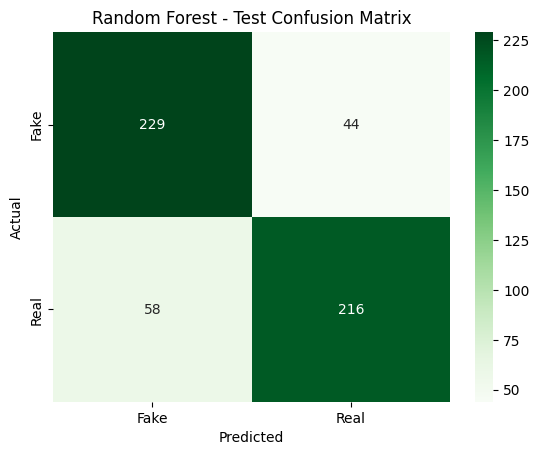


 Tuning Logistic Regression...
Best Params: {'clf__C': 0.1, 'clf__solver': 'lbfgs'}
Saved Logistic Regression model to ../models/logistic_regression_final_model.joblib

Logistic Regression - Results
              precision    recall  f1-score   support

        Fake       0.72      0.70      0.71       273
        Real       0.71      0.73      0.72       274

    accuracy                           0.71       547
   macro avg       0.71      0.71      0.71       547
weighted avg       0.71      0.71      0.71       547



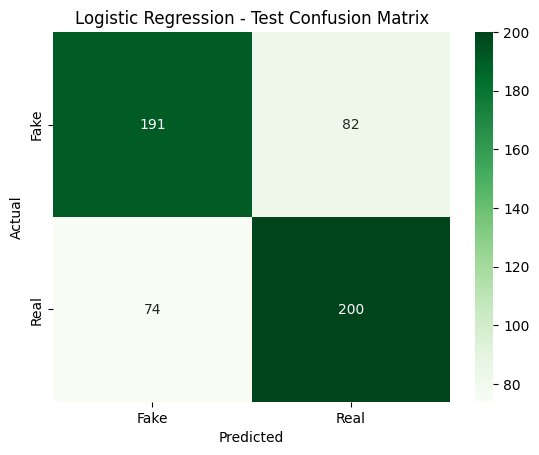

In [53]:
# Load features + labels
features = np.load("../results/gossipcop_features_extended_18.npy")
labels = np.load("../results/gossipcop_labels.npy")
if labels.shape[0] > features.shape[0]:
    labels = labels[:features.shape[0]]

# Split
X_train, X_temp, y_train, y_temp = train_test_split(
    features, labels, test_size=0.30, stratify=labels, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, stratify=y_temp, random_state=42
)

X_trainval = np.concatenate([X_train, X_val], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)

# Pipelines + Param Grids
pipelines = {
    "Random Forest": Pipeline([
        ("clf", RandomForestClassifier(random_state=42))
    ]),
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000))
    ])
}

param_grids = {
    "Random Forest": {
        "clf__n_estimators": [100, 200],
        "clf__max_depth": [None, 10, 20]
    },
    "Logistic Regression": {
        "clf__C": [0.1, 1, 10],
        "clf__solver": ["lbfgs", "saga"]
    }
}

os.makedirs("../models", exist_ok=True)

# Grid Search + Final Evaluation
for name in pipelines:
    print(f"\n Tuning {name}...")
    grid = GridSearchCV(pipelines[name], param_grids[name], cv=3, n_jobs=-1)
    grid.fit(X_trainval, y_trainval)

    print("Best Params:", grid.best_params_)

    # Save best model
    model_path = f"../models/{name.replace(' ', '_').lower()}_final_model.joblib"
    joblib.dump(grid.best_estimator_, model_path)
    print(f"Saved {name} model to {model_path}")

    # Evaluate on test set
    X_test_scaled = grid.best_estimator_.named_steps["scaler"].transform(X_test) if "scaler" in grid.best_estimator_.named_steps else X_test
    y_pred = grid.predict(X_test_scaled)

    print(f"\n{name} - Results")
    print(classification_report(y_test, y_pred, target_names=["Fake", "Real"]))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
    plt.title(f"{name} - Test Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


C:\Users\amohandas\AppData\Local\Temp\ipykernel_27588\1286273093.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x="Importance", y="Feature", palette="viridis")


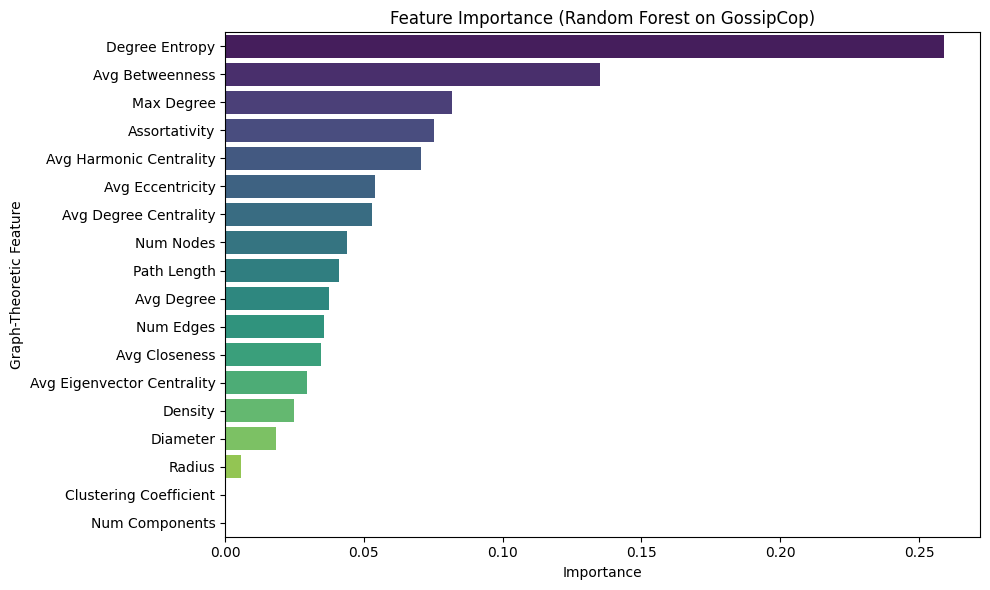

In [54]:
rf_model = joblib.load("../models/random_forest_final_model.joblib")

feature_names = [
    "Num Nodes", "Num Edges", "Avg Degree", "Clustering Coefficient", "Density", "Num Components",
    "Assortativity", "Diameter", "Radius", "Max Degree", "Avg Degree Centrality", "Avg Betweenness",
    "Avg Closeness", "Avg Harmonic Centrality", "Avg Eigenvector Centrality", "Avg Eccentricity",
    "Path Length", "Degree Entropy"
]

importances = rf_model.named_steps["clf"].feature_importances_

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importance (Random Forest on GossipCop)")
plt.xlabel("Importance")
plt.ylabel("Graph-Theoretic Feature")
plt.tight_layout()
plt.show()